# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 07.12.2021


Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()

In [5]:
X = boston["data"]
y = boston["target"]

In [6]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [7]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.1026004648948

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [8]:
def Bootstrap(size):
    train_idxs = np.random.randint(0, size, size)
    return train_idxs, np.array(list(set(np.arange(size)) - set(train_idxs)))
    

def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    error = 0.
    sum_predict = np.zeros(y.shape[0], dtype=float)
    predicts = np.zeros((num_runs, y.shape[0]))
    len_tests = np.zeros((num_runs, y.shape[0]))
    # Другой способ без такого количества памяти - брать variance = error - bias
    mean_predict = np.zeros(y.shape[0])
    for i in range(num_runs):
        
        train, test = Bootstrap(y.shape[0])
        if test.shape[0] == 0:
            continue
        regressor.fit(X[train], y[train])
        pred = regressor.predict(X[test])

        len_tests[i, test] = 1
        mean_predict[test] += pred
        predicts[i, test] = pred

        one_error = (pred - y[test]) ** 2
        error += one_error.mean()
    
    mean_predict[len_tests.sum(axis=0) != 0] /= len_tests.sum(axis=0)[len_tests.sum(axis=0) != 0]
    variance = (((predicts - mean_predict * len_tests) ** 2).sum() / len_tests.sum()).mean()
    bias = ((mean_predict - y)[len_tests.sum(axis=0) != 0] ** 2).mean()
    error /= num_runs
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [7]:
compute_biase_variance(LinearRegression(), X, y)

(23.726629084091073, 0.9426792026524907, 24.837772009821883)

In [8]:
compute_biase_variance(DecisionTreeRegressor(), X, y)

(10.272259175713463, 13.023162419251896, 23.330215097203382)

In [9]:
compute_biase_variance(RandomForestRegressor(), X, y, 100)

(10.548961114291123, 2.2563251443654266, 12.901486575443412)

__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Полностью согласованы с теорией.
* Линейная модель не может приблизить хорошо приблизить реальность даже в теории, поэтому смещение велик. Но сами модели довольно схожи.
* Дерево может гораздо ближе приблизить реальность, однако очень чувствительна к выборке.
* Рандомный лес имеет + дерева, и за счёт своих свойств сильно разброс.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__ 
* Линейные модели очень слабо меняются от выборки, а бэггинг им не очень поможет, потому что модели будут схожими, что мы и видим.
* Деревья выиграют больше всех, потому что они очень зависят от выборки.
* Рандом леса в целом выиграют, потому что они всё же зависят от выборки, но гораздо меньше чем деревья. И это компенсируется смещением.

In [10]:
from copy import deepcopy

def MakeRandomIdxs(size, prob_drop=0.9):
    return np.random.randint(0, size, int(size * prob_drop))

class BaggModel():
    def __init__(self, model, count_of_models=20):
        self.cnt = count_of_models
        self.model = []
        for i in range(self.cnt):
            self.model.append(deepcopy(model))

    def fit(self, X, y):
        for i in range(self.cnt):
            train = MakeRandomIdxs(X.shape[0])
            self.model[i].fit(X[train], y[train])

    def predict(self, X):
        predict = np.zeros(X.shape[0])
        for i in range(self.cnt):
            predict += self.model[i].predict(X) / self.cnt

        return predict

In [12]:
compute_biase_variance(BaggModel(LinearRegression()), X, y, 100)

(23.78512550147443, 0.9853907768430392, 24.551300509364935)

In [13]:
compute_biase_variance(BaggModel(DecisionTreeRegressor()), X, y, 100)

(10.39939427944177, 2.580622981361021, 12.86436492824371)

In [14]:
compute_biase_variance(BaggModel(RandomForestRegressor(), 10), X, y, 50)

(11.42098806657458, 1.5067420945296888, 12.578683409813175)

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [11]:
def plot_predictions(ax, regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    test = np.random.choice(np.arange(X.shape[0]), num_test_objects, replace=False)
    train = np.array(list(set(np.arange(X.shape[0])) - set(test)))
    for i in range(num_runs):
        train_i, _ = Bootstrap(train.shape[0])
        regressor.fit(X[train][train_i], y[train][train_i])
        pred = regressor.predict(X[test])
        ax.scatter(np.arange(num_test_objects), pred, color='r')
    
    ax.scatter(np.arange(num_test_objects), y[test], color='b')
    ax.set_title(title)
    ax.set_xlabel('Objects')
    ax.set_ylabel('Predictions')

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

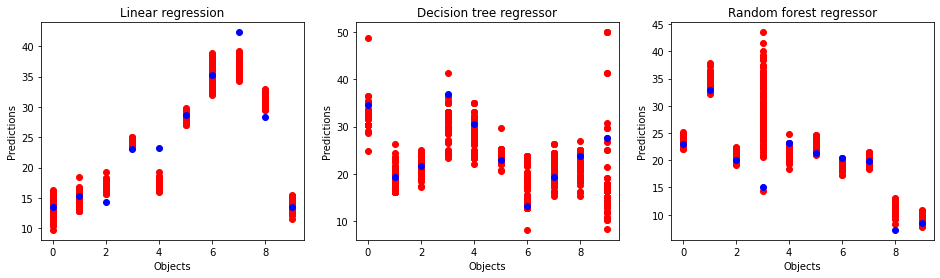

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plot_predictions(axs[0], LinearRegression(), X, y, title='Linear regression')
plot_predictions(axs[1], DecisionTreeRegressor(), X, y, title='Decision tree regressor')
plot_predictions(axs[2], RandomForestRegressor(), X, y, title='Random forest regressor')

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
* График линейной регрессии показывает кучные результаты, а значит небольшой разброс, однако они могут быть совсем не в нужном месте, что показывает большое смещение.
* График дерева решений показывает высокий разброс, но и более низкое смещение (почти везде был хоть иногда очень близко).
* Рандом форест кучные и точные результаты (кроме 3 переменной, возможно это просто выброс)

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [56]:
bias_over_depth = []
variance_over_depth = []
bias_over_features = []
variance_over_features = []
for i in range(1, 11):
    bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=i), X, y, 100)
    bias_over_depth.append(bias)
    variance_over_depth.append(variance)

for i in range(1, X.shape[1]):
    bias, variance, _ = compute_biase_variance(DecisionTreeRegressor(max_features=i), X, y, 100)
    bias_over_features.append(bias)
    variance_over_features.append(variance)

In [27]:
def PlotErrors(ax, bias, variance, title='', x_label = None, y_label='Error'):
    if x_label is None:
        x_label = title

    ax.plot(np.arange(1, len(variance) + 1), variance, color='r', label='variance')
    ax.plot(np.arange(1, len(bias) + 1), bias, color='b', label='bias')
    ax.set_title(title + ' over errors')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()

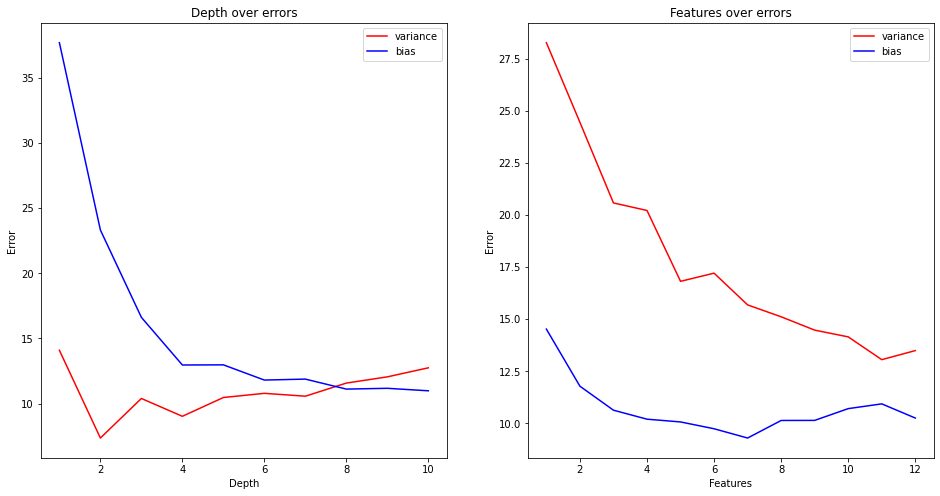

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
PlotErrors(axs[0], bias_over_depth, variance_over_depth, 'Depth')
PlotErrors(axs[1], bias_over_features, variance_over_features, 'Features')

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

bias_n_forest = []
variance_n_forest = []
bias_n_boosting = []
variance_n_boosting = []
for i in 2 ** np.arange(1, 10):
    bias, variance, _ = compute_biase_variance(RandomForestRegressor(n_estimators=i), X, y, 100)
    bias_n_forest.append(bias)
    variance_n_forest.append(variance)

    bias, variance, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=i), X, y, 100)
    bias_n_boosting.append(bias)
    variance_n_boosting.append(variance)

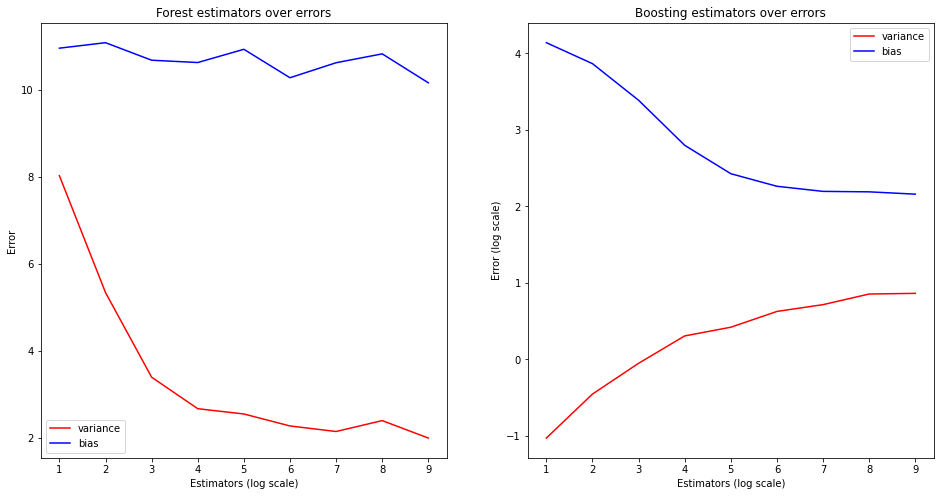

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
PlotErrors(axs[0], bias_n_forest, variance_n_forest, 'Forest estimators', 'Estimators (log scale)')
PlotErrors(axs[1], np.log(bias_n_boosting), np.log(variance_n_boosting), 'Boosting estimators', 'Estimators (log scale)', 'Error (log scale)')

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
* Как и ожидалось (в лекциях) рандомный лес при большем количестве деревьев уменьшает разброс, при этом смещение примерно одно и тоже, потому что оно равно смещению 1 оценивателя (дерева).
* **Оффтоп:** график в лог шкале по у. Очевидно, что графдиентный бустинг подгоняет простые модели под сложную выборку. Поэтому смещение уменьшается, а разброс растёт (но не сильно).

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

![Easy peezy :)](squeezed_lemon.jpg)